In [2]:
import torch
import torch.nn as nn
import torch.distributions as tdist

import dataloader

In [35]:
class DiffusionModel(nn.Module):
    def __init__(self, beta):
        super(DiffusionModel, self).__init__()
        self.device = device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.beta = beta.to(self.device) # Decay schedule
        self.T = beta.shape[0]
        
        self.c1 = nn.Conv2d(1, 10, 3, padding=1)
        self.b1 = nn.GroupNorm(1, 10)
        
        self.c2 = nn.Conv2d(10, 10, 3, padding=1)
        self.b2 = nn.GroupNorm(1, 10)
        
        self.c3 = nn.Conv2d(10, 10, 3, padding=1)
        self.b3 = nn.GroupNorm(1, 10)
        
        self.c4 = nn.Conv2d(10, 10, 3, padding=1)
        self.b4 = nn.GroupNorm(1, 10)
        
        self.c5 = nn.Conv2d(10, 10, 3, padding=1)
        self.b5 = nn.GroupNorm(1, 10)
        
        self.c6 = nn.Conv2d(10, 10, 3, padding=1)
        self.b6 = nn.GroupNorm(1, 10)
        
        self.c7 = nn.Conv2d(10, 10, 3, padding=1)
        self.b7 = nn.GroupNorm(1, 10)
        
        self.c8 = nn.Conv2d(10, 10, 3, padding=1)
        self.b8 = nn.GroupNorm(1, 10)
        
        self.c9 = nn.Conv2d(10, 10, 3, padding=1)
        self.b9 = nn.GroupNorm(1, 10)
        
        self.c10 = nn.Conv2d(10, 10, 3, padding=1)
        self.b10 = nn.GroupNorm(1, 10)
        
        self.c11 = nn.Conv2d(10, 10, 3, padding=1)
        self.b11 = nn.GroupNorm(1, 10)
        
        self.c12 = nn.Conv2d(10, 10, 3, padding=1)
        self.b12 = nn.GroupNorm(1, 10)
        
        self.c13 = nn.Conv2d(10, 1, 3, padding=1)
        
        self.relu = nn.ReLU()
        
    def alphabar(self, t):
        alpha = torch.zeros(t.shape[0], device=self.device)
        for idx, s in enumerate(t):
            alpha[idx] = torch.prod(1 - self.beta[0:s])
        return alpha
    
    def embedtime(self, t, embedding_size, dimensions):
        w = 1.0 / (10000 ** (torch.arange(0, embedding_size, 2, dtype=torch.float32) / embedding_size))
        y = torch.sin(t.view(t.shape[0], 1).repeat(1, embedding_size // 2) * w)
        x = torch.cos(t.view(t.shape[0], 1).repeat(1, embedding_size // 2) * w)
        return torch.cat([x, y], dim=1).view(-1, embedding_size, 1, 1).repeat(1, 1, dimensions, dimensions)
    
    def sample_image(self):
        samples = torch.zeros((self.T + 1, 784), device=self.device)
        
        samples[self.T] = torch.randn(784, device=self.device)
        
        with torch.no_grad():
            for t in torch.arange(self.T - 1, 0, -1):
                beta = self.beta[t]
                alfa = 1 - beta
                alfabar = self.alphabar(torch.tensor([t + 1], device=self.device))
                z = torch.randn(784, device=self.device)
                xt = samples[t + 1]
                eps = self.forward(xt.view(1, 1, 28, 28), torch.tensor([t + 1], device=self.device)).view(784)
                samples[t] = (xt - beta * eps / (torch.sqrt(1 - alfabar))) / torch.sqrt(alfa) + torch.sqrt(beta) * z
            
            beta = self.beta[0]
            alfa = 1 - beta
            alfabar  = self.alphabar(torch.tensor([1], device=self.device))
            xt = samples[1]
            eps = self.forward(xt.view(1, 1, 28, 28), torch.tensor([1], device=self.device)).view(784)
            samples[0] = (xt - beta * eps / (torch.sqrt(1 - alfabar))) / torch.sqrt(alfa)
        
        return samples
        
    def forward(self, x, t):
        T = self.embedtime(t, 10, 28)
        
        x = self.c1(x) + T
        x = self.relu(x)
        
        x = self.c2(x) + T
        x = self.relu(x)
        
        x = self.c3(x) + T
        x = self.relu(x)
        
        x = self.c4(x) + T
        x = self.relu(x)
        
        x = self.c5(x) + T
        x = self.relu(x)
        
        x = self.c6(x) + T
        x = self.relu(x)
        
        x = self.c7(x) + T
        x = self.relu(x)
        
        x = self.c8(x) + T
        x = self.b8(x)
        x = self.relu(x)
        
        x = self.c9(x) + T
        x = self.b9(x)
        x = self.relu(x)
        
        x = self.c10(x) + T
        x = self.b10(x)
        x = self.relu(x)
        
        x = self.c11(x) + T
        x = self.b11(x)
        x = self.relu(x)
        
        x = self.c12(x) + T
        x = self.b12(x)
        x = self.relu(x)
        
        x = self.c13(x)
        
        return x

In [68]:
def train_diff(epoch, model, optimizer, loss_function, train_loader):
    model.train() # so that everything was gradients and we can do backprop and so on...
    train_loss = 0
    input = torch.zeros((train_loader.batch_size, 784), device = model.device)
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, 784)
        optimizer.zero_grad() # "reset" gradients to 0 for text iteration
        
        t = torch.randint(1, model.T, (train_loader.batch_size,))
        eps = torch.normal(0, 1, (train_loader.batch_size, 784))
        alf = model.alphabar(t)
        for idx, x in enumerate(data):
            input[idx] = torch.sqrt(alf[idx]) * data[idx] + torch.sqrt(1 - alf[idx]) * eps[idx]
        eps_nn = model(input.view(-1, 1, 28, 28), t)
        loss = loss_function(eps.view(-1, 784), eps_nn.view(-1, 784))
        loss.backward()
        train_loss += loss.item()
        optimizer.step() # backpropagation
        
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [36]:
model = DiffusionModel(torch.linspace(1e-4, 0.02, 1000))
loss = nn.MSELoss()
train_loader, test_loader = dataloader.setup_data_loaders(batch_size=512, use_cuda=False)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [70]:
EPOCHS = 10
for epoch in range(EPOCHS):
    train_diff(epoch, model, optimizer, loss, train_loader)

KeyboardInterrupt: 

In [63]:
test = model.sample_image()

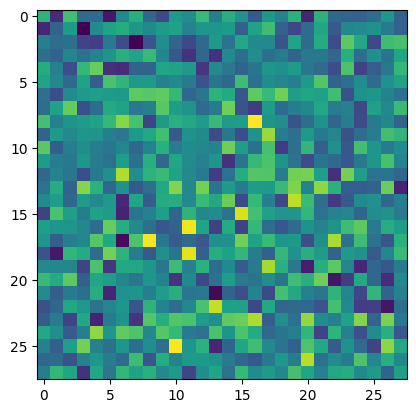

In [66]:
import matplotlib.pyplot as plt

sigmoid = nn.Sigmoid()
plt.imshow(test[500].view(28, 28))

In [198]:
def embedtime(self, t, embedding_size, dimensions):
    emb = torch.zeros((embedding_size // 2) * t.shape[0]).reshape(t.shape[0], embedding_size // 2)
    emb2 = torch.zeros((embedding_size // 2) * t.shape[0]).reshape(t.shape[0], embedding_size // 2)
    s = torch.linspace(torch.tensor(2), torch.tensor(embedding_size // 2), torch.tensor(embedding_size // 2, dtype=int))
    for idx, samp in enumerate(t):
        emb[idx] = torch.sin(2 * s * torch.pi * samp / self.T)
        emb2[idx] = torch.cos(2 * s * torch.pi * samp / self.T)

    return torch.cat([emb, emb2], dim = 1).view(-1, embedding_size, 1, 1).repeat(1, 1, dimensions, dimensions)

torch.Size([16, 8, 8])

In [193]:
x.shape

torch.Size([3, 8])

In [ ]:
def pos_encoding(self, t, channels, embed_size):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc.view(-1, channels, 1, 1).repeat(1, 1, embed_size, embed_size)

In [177]:
a = torch.tensor([2]).repeat(1, 32 // 2) * torch.arange(0, 32, 2)
b = a = torch.tensor([2]).repeat(1, 32 // 2) * torch.arange(0, 32, 2)
torch.cat([a, b], dim = 1).view(-1, 32, 1, 1).repeat(1, 1, 16, 16)[0][1].shape

torch.Size([16, 16])